### idea here is to produce functions that do beersheba work, but also output the difference between iterations so that they can be tracked

In [84]:
import sys,os,os.path
sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'


# gif making packages
import imageio
import re
#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook



import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import math as m
import pandas as pd
import numpy  as np
import tables as tb

import time
from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize



## Starting functions

In [65]:
# human sorting
def tryint(s):
    """
    Return an int if possible, or `s` unchanged.
    """
    try:
        return int(s)
    except ValueError:
        return s

def alphanum_key(s):
    """
    Turn a string into a list of string and number chunks.

    >>> alphanum_key("z23a")
    ["z", 23, "a"]

    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def human_sort(l):
    """
    Sort a list in the way that humans expect.
    """
    l.sort(key=alphanum_key)



def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)






def soph_to_lowTh(df, threshold = 5):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process
    Made by me (John Waiton), so dont treat it like a normal function from IC!
    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

    # safety check, to ensure you don't accidentally make a repeating dataframe
    


    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())

    print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (len(soph_hitc_list)%j == 50): 
            print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df



## beersheba parameters

In [9]:
# Input file and some event IDs to look at.
dist = 12
typefile = 'esmeralda' #'esmeralda'
#file = f'/Users/halmamol/NEXT/files/NEXT100/separated/esmeralda/esmeralda_10_sep.h5'
#file = f'../../../Tl_studies/LPR/208Tl/PORT_2a/prod/esmeralda/esmeralda_180_208Tl.h5'
#file = f'/Users/halmamol/NEXT/files/FLEX/ELdistMask/Xe/bb0nu/{typefile}/NextFlex.bb0nu.FLEXELdist{dist}mask.0.detsim.h5'
evts = [90] #15, 30, 90
pitch = 15.55
detector_db     = '../../IC/invisible_cities/database/localdb.NEXT100DB.sqlite3'

run_number      = -1

datatype = 'MC'


# Parameters involved in beersheba city and the deconvolution.

'''
## FROM OLD TESTING
deconv_params = dict(
  q_cut           = 5, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = f'../data/data/LightTables/NEXT100_PSF_kr83m.h5',     
  e_cut           = 6e-3, #15 for 6mm  - 15 for 6mm
  n_iterations    = 100, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-10,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint)#,
 # energy_type     = HitEnergy.Ec,
 # cut_type        = CutType.abs,
 # inter_method    = InterpolationMethod.cubic)
'''

# new parameters for threshold
pes = 1
thresh = 4
threshold = thresh * pes
same_peak = True

deconv_params = dict(
                  drop_dist       = [16., 16.],
                  psf_fname       = f'/home/e78368jw/Documents/NEXT_CODE/Tl_studies/LPR/LightTables/NEXT100_PSF_kr83m_5bar.h5',
                  q_cut           = thresh,                   # WE HAVE MANUALLY CHANGED THIS FROM 10 -> 5 HERE
                  e_cut           = 9e-3,                # WE HAVE MANUALLY CHANGED THIS FROM 12e-3 TO 6e-3
                  n_iterations    = 150,
                  iteration_tol   = 1e-10,
                  sample_width    = [15.55, 15.55],
                  bin_size        = [ 1.,  1.],
                  satellite_iter  = 50,                       # after how many iterations do you start scanning? 
                  satellite_dist  = 2,                        # how far away do two clouds have to be to be considered unique
                  satellite_size  = 10,                       # maximum size of satellites, beyond which they are considered signal.
                  energy_type     = HitEnergy.Ec,               #Removing these variables because they were previously? 
                  diffusion       = (1.440, 1.440),
                  deconv_mode     = DeconvolutionMode.joint,
                  n_dim           = 2,
                  cut_type        = CutType.abs,              #Removing these variables because they were previously?
                  inter_method    = InterpolationMethod.cubic)            #Removing these variables because they were previously?  




#DeconvolutionMode
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.
cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

In [10]:
#soph_file = f'../../../next_misc/Tl_studies/sophronia/sophronia_qthr2.h5'
soph_file = f'/home/e78368jw/Documents/NEXT_CODE/next_misc/energy_topology_study/testing_data/sophronia_27_208Tl.h5'
soph_hdst = dstio.load_dst(soph_file, 'RECO', 'Events')#CHITS/lowTh

# load in MC just to look at the raw event
if (datatype == 'MC'):
    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(soph_file).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)

# Name of directory the plots are going into
#pre_dir_name = 'qthr2_plot/'

# set q_thr value here
thresh = 4


display(soph_hdst)
display(true_info)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,520000,5.200012e+11,0,237.823620,-217.509278,1,225.475,-225.475,0.0,0.0,369.512128,5.101449,236.734026,-1.0,0.000766,-1,-1.0
1,520000,5.200012e+11,0,237.823620,-217.509278,1,225.475,-209.925,0.0,0.0,369.512128,10.144928,470.777938,-1.0,0.001512,-1,-1.0
2,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-241.025,0.0,0.0,369.512128,4.811594,223.283232,-1.0,0.000741,-1,-1.0
3,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-225.475,0.0,0.0,369.512128,13.913044,645.638310,-1.0,0.002115,-1,-1.0
4,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-209.925,0.0,0.0,369.512128,18.144928,842.019953,-1.0,0.002748,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147151,520640,5.206420e+11,1,347.356042,323.206374,1,349.875,318.775,0.0,0.0,670.050544,5.913043,188.888896,-1.0,0.000849,-1,-1.0
147152,520640,5.206420e+11,1,347.356042,323.206374,1,349.875,334.325,0.0,0.0,670.050544,5.275362,168.518515,-1.0,0.000608,-1,-1.0
147153,520640,5.206420e+11,1,347.356042,323.206374,1,365.425,318.775,0.0,0.0,670.050544,6.492754,207.407411,-1.0,0.001296,-1,-1.0
147154,520640,5.206420e+11,1,347.356042,323.206374,1,365.425,334.325,0.0,0.0,670.050544,4.521739,144.444446,-1.0,0.000521,-1,-1.0


,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,520000,20,0,253.886749,-212.319138,372.275421,2.148397,0.000092,ACTIVE
1,520000,29,0,253.886856,-212.319183,372.275391,2.148428,0.000044,ACTIVE
2,520000,28,0,253.886703,-212.319138,372.275391,2.148409,0.000047,ACTIVE
3,520000,27,0,253.886734,-212.319275,372.275391,2.148433,0.000046,ACTIVE
4,520000,26,0,253.886749,-212.319138,372.275421,2.148405,0.000010,ACTIVE
...,...,...,...,...,...,...,...,...,...
116755,520640,58,21,415.383545,108.210579,127.116730,2.283214,0.000718,ACTIVE
116756,520640,58,22,415.374542,108.207016,127.114326,2.283445,0.001311,ACTIVE
116757,520640,58,23,415.372498,108.212456,127.117752,2.283624,0.001543,ACTIVE
116758,520640,58,24,415.369202,108.211823,127.116798,2.283741,0.001976,ACTIVE


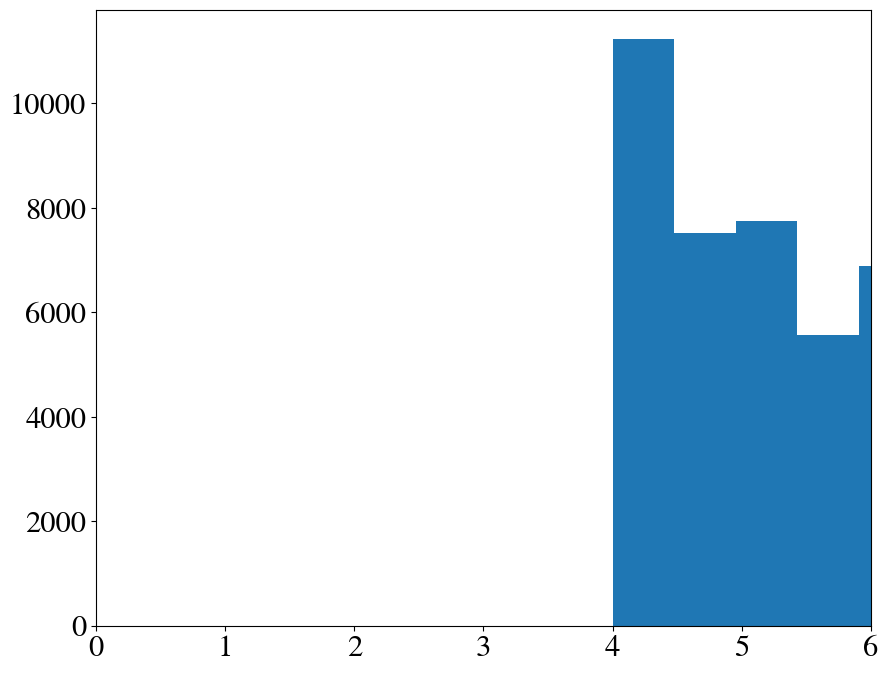

In [11]:
plt.hist(soph_hdst.Q.to_numpy(), bins = 1000)
plt.xlim([0,6])
plt.show()

In [12]:
# this line isnt needed, as q_thr already set to 4
#hdst = soph_to_lowTh(soph_hdst, threshold = thresh)
hdst = soph_hdst

# all the annoying beersheba stuff here

you have rewrote a couple of the functions to be nicer for a stupid input (one slice)

In [122]:
import numpy  as np
import tables as tb
import pandas as pd

from os   .path  import expandvars
from scipy.stats import multivariate_normal
from numpy       import nan_to_num

from typing import Tuple
from typing import List
from typing import Optional

from IC.invisible_cities.cities.components import city
from IC.invisible_cities.cities.components import collect
from IC.invisible_cities.cities.components import copy_mc_info
from IC.invisible_cities.cities.components import print_every
from IC.invisible_cities.cities.components import hits_corrector
from IC.invisible_cities.cities.components import hits_thresholder
from IC.invisible_cities.cities.components import hits_and_kdst_from_files
from IC.invisible_cities.cities.components import identity

from IC.invisible_cities.core.configure         import EventRangeType
from IC.invisible_cities.core.configure         import OneOrManyFiles
from IC.invisible_cities.core.configure         import check_annotations

from IC.invisible_cities.reco                   import tbl_functions           as tbl
from IC.invisible_cities.dataflow               import dataflow                as fl

from IC.invisible_cities.dataflow.dataflow      import push
from IC.invisible_cities.dataflow.dataflow      import pipe

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.reco.deconv_functions  import find_nearest
from IC.invisible_cities.reco.deconv_functions  import cut_and_redistribute_df
from IC.invisible_cities.reco.deconv_functions  import drop_isolated_sensors
from IC.invisible_cities.reco.deconv_functions  import deconvolve
from IC.invisible_cities.reco.deconv_functions  import richardson_lucy

from IC.invisible_cities.io.run_and_event_io    import run_and_event_writer
from IC.invisible_cities.io.          dst_io    import df_writer
from IC.invisible_cities.io.          dst_io    import load_dst
from IC.invisible_cities.io.         hits_io    import hits_writer
from IC.invisible_cities.io. event_filter_io    import event_filter_writer
from IC.invisible_cities.io.         kdst_io    import kdst_from_df_writer

from IC.invisible_cities.types.symbols          import HitEnergy
from IC.invisible_cities.types.symbols          import InterpolationMethod
from IC.invisible_cities.types.symbols          import CutType
from IC.invisible_cities.types.symbols          import DeconvolutionMode

from IC.invisible_cities.core                   import system_of_units as units




import numpy  as np
import pandas as pd

from typing  import List
from typing  import Tuple
from typing  import Callable

from scipy                  import interpolate
from scipy.signal           import fftconvolve
from scipy.signal           import convolve
from scipy.spatial.distance import cdist
from scipy import ndimage as ndi

from IC.invisible_cities.core .core_functions import shift_to_bin_centers
from IC.invisible_cities.core .core_functions import in_range

from IC.invisible_cities.types.symbols       import InterpolationMethod

import warnings

## Just here for testing, remove after finished testing
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import colors



def isolate_satellites(data, connectivity = 2, min_size = 10):
    '''
    An adapted function from scikit-image
    https://github.com/scikit-image/scikit-image/blob/main/skimage/morphology/misc.py#L59-L151
    Pulled in here because of package mismatches (scikit-image breaks my conda env, this is easier I think)
    set min_size to 10-ish (testing), as per-iteration you wouldn't expect more than 4 pixels (interpolated) to be formed by a satellite
    connectivity set to 2 to catch diagonals

    Separates blobs below a certain size that are distinct.
    '''
    try:
        array = data.copy().astype(bool)
    except:
        print("Please ensure the array passed through is boolean compatible.")
    # Not connections if satellite size is zero
    if min_size == 0:
        warning.warn(f'Satellite size set to zero. No satellites will be removed')
        return array # will cause the result to be identical to the input


    # label the blobs within the array
    footprint = ndi.generate_binary_structure(array.ndim, connectivity)
    ccs = np.zeros_like(array, dtype=np.int32)
    ndi.label(array, footprint, output=ccs)
    
    # count the bins of each labelled blob
    try:
        component_sizes = np.bincount(ccs.ravel())
    except ValueError:
        raise ValueError("Negative value labels are not supported.")

    # check if no-satellites
    if len(component_sizes) == 2:
        return array
    
    too_small = component_sizes < min_size
    too_small_mask = too_small[ccs]
    array[too_small_mask] = 0

    return array


def deconvolve(n_iterations  : int,
               iteration_tol : float,
               sample_width  : List[float],
               det_grid      : List[np.ndarray],
               inter_method  : InterpolationMethod = InterpolationMethod.cubic
               ) -> Callable:
    """
    Deconvolves a given set of data (sensor position and its response)
    using Lucy-Richardson deconvolution.

    Parameters
    ----------
    data        : Sensor (hits) position points.
    weight      : Sensor charge for each point.
    psf         : Point-spread function.

    Initialization parameters:
        n_iterations  : Number of Lucy-Richardson iterations
        iteration_tol : Stopping threshold (difference between iterations).
        sample_width  : Sampling size of the sensors.
        det_grid      : xy-coordinates of the detector grid, to interpolate on them
        inter_method  : Interpolation method.

    Returns
    ----------
    deconv_image : Deconvolved image.
    inter_pos     : Coordinates of the deconvolved image.
    """

    print("outwith deconvolve")
    var_name     = np.array(['xr', 'yr', 'zr'])
    deconv_input = deconvolution_input(sample_width, det_grid, inter_method)

    def deconvolve(data   : Tuple[np.ndarray, ...],
                   weight : np.ndarray,
                   psf    : pd.DataFrame,
                   satellite_iter  : int,
                   satellite_dist  : int,
                   satellite_size  : int,
                   e_cut  : float,
                   z_flag : bool
                  ) -> Tuple[np.ndarray, Tuple[np.ndarray, ...]]:

        #print("within deconvolve")
        #display(data)
        #display(weight)


        inter_signal, inter_pos = deconv_input(data, weight)
        z_flag = True
        if (z_flag == True):
            #q = plt.scatter(data[0],data[1],c = weight) # plot the real stuff here
            #plt.colorbar(q)
            #plt.title('SiPM output')
            #plt.xlabel('x (mm)')
            #plt.ylabel('y (mm)')
            #plt.show()
            
            my_cmap = cm.get_cmap("viridis").with_extremes(under = "white")

            r = plt.scatter(inter_pos[0], inter_pos[1], c = inter_signal, vmin = 1e-3, cmap=my_cmap)
            #np.save('inter_pos_0.npy', inter_pos[0])
            #np.save('inter_pos_1.npy', inter_pos[1])
            #np.save('inter_sig.npy', inter_signal)
            plt.colorbar(r)
            plt.xlabel('x (mm)')
            plt.ylabel('y (mm)')
            plt.title('Interp output')
            plt.show()

        columns       = var_name[:len(data)]
        psf_deco      = psf.factor.values.reshape(psf.loc[:, columns].nunique().values)
        deconv_image  = np.nan_to_num(richardson_lucy(inter_signal, inter_pos, psf_deco, satellite_iter,
                                                      satellite_dist, satellite_size, e_cut,
                                                      n_iterations, iteration_tol, z_flag))
        #print("Deconv done")
        return deconv_image, inter_pos

    return deconvolve
                           # \/\/\/ added for visualising 
def richardson_lucy(image, inter_pos, psf, satellite_iter, satellite_dist, satellite_size, e_cut, iterations=50, iter_thr=0., z_flag = False):
    """Richardson-Lucy deconvolution (modification from scikit-image package).

    The modification adds a value=0 protection, the possibility to stop iterating
    after reaching a given threshold and the generalization to n-dim of the
    PSF mirroring.

    Parameters
    ----------
    image : ndarray
       Input degraded image (can be N dimensional).
    psf : ndarray
       The point spread function.
    iterations : int, optional
       Number of iterations. This parameter plays the role of
       regularisation.
    iter_thr : float, optional
       Threshold on the relative difference between iterations to stop iterating.

    Returns
    -------
    im_deconv : ndarray
       The deconvolved image.
    Examples
    --------
    >>> from skimage import color, data, restoration
    >>> camera = color.rgb2gray(data.camera())
    >>> from scipy.signal import convolve2d
    >>> psf = np.ones((5, 5)) / 25
    >>> camera = convolve2d(camera, psf, 'same')
    >>> camera += 0.1 * camera.std() * np.random.standard_normal(camera.shape)
    >>> deconvolved = restoration.richardson_lucy(camera, psf, 5)
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
    """
    
    # some quick additions
    plot_gifs = False
    rel_diff_array = []
    
    
    # compute the times for direct convolution and the fft method. The fft is of
    # complexity O(N log(N)) for each dimension and the direct method does
    # straight arithmetic (and is O(n*k) to add n elements k times)
    
    direct_time = np.prod(image.shape + psf.shape)
    fft_time    = np.sum([n*np.log(n) for n in image.shape + psf.shape])

    # see whether the fourier transform convolution method or the direct
    # convolution method is faster (discussed in scikit-image PR #1792)
    time_ratio = 40.032 * fft_time / direct_time

    if time_ratio <= 1 or len(image.shape) > 2:
        convolve_method = fftconvolve
    else:
        convolve_method = convolve

    image      = image.astype(float)
    psf        = psf.astype(float)
    im_deconv  = 0.5 * np.ones(image.shape)
    s          = slice(None, None, -1)
    psf_mirror = psf[(s,) * psf.ndim] ### Allow for n-dim mirroring.
    eps        = np.finfo(image.dtype).eps ### Protection against 0 value
    ref_image  = image/image.max()

    # variable controlling how regularly iterations are broken up
    iteration_no = satellite_iter
    for i in range(iterations):
        if (z_flag == True):
            from matplotlib.colors import LogNorm
            im_vis = im_deconv.copy()
            im_vis[im_vis < 9e-3] = 0
            im_vis[im_vis >= 9e-3] = 1

            if (plot_gifs == True):
                my_cmap = cm.get_cmap("binary").with_extremes(under = "white")


                r = plt.scatter(inter_pos[0], inter_pos[1], c = im_vis, vmin = 1e-3, cmap=my_cmap)
                plt.colorbar(r)
                plt.xlabel('x (mm)')
                plt.ylabel('y (mm)')
                #plt.imshow(im_deconv, norm=LogNorm(vmin = im_deconv.min(), vmax = im_deconv.max()))
                #plt.imshow(im_deconv)
                plt.title("mask " + str(i) + "th iteration across Z slice")
                plt.savefig('gif_making_folder/mask/iter' + str(i) + '.png')
                plt.close()

                #plt.imshow(im_deconv, norm=LogNorm(vmin = im_deconv.min(), vmax = im_deconv.max()))
                plt.imshow(im_deconv)
                plt.title("deconv " + str(i) + "th iteration across Z slice")
                plt.savefig('gif_making_folder/deconv/iter' + str(i) + '.png')
                plt.close()



        x = convolve_method(im_deconv, psf, 'same')
        np.place(x, x==0, eps) ### Protection against 0 value
        relative_blur = image / x
        im_deconv *= convolve_method(relative_blur, psf_mirror, 'same')

        # after every iteration, kill satellites (size 1)
        if (i > iteration_no):
            # apply mask to a copy
            im_vis = im_deconv.copy()
            im_vis[im_vis < e_cut] = 0
            im_vis[im_vis >= e_cut] = 1



            # create mask
            satellite_mask = isolate_satellites(im_vis, satellite_dist, satellite_size)
            # remove only satellite regions!
            deconv_mask = (im_vis + satellite_mask) % 2 == 0

            # apply mask
            im_deconv[~deconv_mask] = 0
            

        #with np.errstate(divide='ignore', invalid='ignore'):
        rel_diff = np.sum(np.nan_to_num(np.divide(((im_deconv/im_deconv.max() - ref_image)**2), ref_image)))
        if m.isnan(rel_diff):

            for ichi in range(len(im_deconv)):
                for j in range(len(im_deconv[ichi])):
                    testing_var = np.sum(np.divide(((im_deconv[ichi][j]/im_deconv[ichi][j].max() - ref_image[ichi][j])**2), ref_image[ichi][j]))
                    if m.isnan(testing_var):
                        print("NaN found for values:\nim_deconv {}\nref_image {}".format(im_deconv[ichi][j], ref_image[ichi][j]))

            print("NaN spotted! Iteration {}\nPrinting reference image".format(i))
            plt.imshow(ref_image)
            plt.title('reference image')
            plt.show()
            plt.imshow(im_deconv/im_deconv.max())
            plt.title('deconv_norm')
            plt.show()
            plt.imshow((im_deconv/im_deconv.max() - ref_image)**2)
            plt.title("deconv_norm - ref image iter " +str(i))
            plt.show()
            plt.imshow(np.divide(((im_deconv/im_deconv.max() - ref_image)**2), ref_image))
            plt.title('divide by ref image')
            plt.show()
        #q = plt.imshow(((im_deconv/im_deconv.max() - ref_image)**2))
        #plt.colorbar(q)
        #plt.title('deconv_norm - ref image iter ' + str(i))
        #plt.savefig('gif_making_folder/iterthr/iter' + str(i) + '.png')
        #plt.close()
        #plt.show()
        
        rel_diff_array.append(rel_diff)
        
        if rel_diff < iter_thr: ### Break if a given threshold is reached.
            break
        
        
        ref_image = im_deconv/im_deconv.max()

    # documentation tags
    #if (z_flag == True):
    #    np.save('inter_post_deco.npy', im_deconv)

    # plot the rel_diff array
    print(rel_diff_array)
    plot_iterations = np.linspace(1, iterations, iterations)
    plt.plot(plot_iterations, rel_diff_array)
    plt.yscale('log')
    plt.title('Relative difference between iterations over iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Relative difference')
    plt.show()

    #if (plot_gifs == True):
    # generate the gifs in the correct folder
    print()
    base_dir = str(os.getcwd()) + "/"
    pa = Path('./gif_making_folder/')
    gif_dirs = [f for f in pa.iterdir() if f.is_dir()]


    print(gif_dirs)
    for dirs in gif_dirs:
        print("Directory " + str(dirs))
        active_dir = base_dir + str(dirs) + '/'
        files = [f for f in os.listdir(active_dir) if os.path.isfile(os.path.join(active_dir, f))]

        # sort files in a human manner
        files.sort(key=alphanum_key)
        print(files)
        images = []
        for filename in files:
            images.append(imageio.imread(active_dir + filename))
        
        print("Saving gif at " + str(base_dir))
        imageio.mimsave(base_dir + 'gif_making_folder/' + str(dirs).split('/')[1] + '.gif', images, loop = 0, fps = 10)


    return im_deconv

def distribute_energy(df, cdst, energy_type):
    '''
    Assign the energy of a dataframe (cdst) to another dataframe (deconvolved),
    distributing it according to the charge fraction of each deconvolution hit.

    Parameters
    ----------
    df          : Deconvolved dataframe with a single S2 (npeak)
    cdst        : Dataframe with the sensor response (usually a cdst)
    energy_type : HitEnergy with which 'type' of energy should be assigned.
    '''
    df.loc[:, 'E'] = df.E / df.E.sum() * cdst.loc[:, energy_type.value].sum()



def z_slice_deconvolve(det_db          : pd.DataFrame,
                      df,
                      z,
                      psf_fname       : str,
                      e_cut           : float,
                      n_iterations    : int,
                      iteration_tol   : float,
                      sample_width    : List[float],
                      bin_size        : List[float],
                      satellite_iter  : int,
                      satellite_dist  : int,
                      satellite_size  : int,
                      diffusion       : Optional[Tuple[float, float, float]]=(1., 1., 0.3),
                      energy_type     : Optional[HitEnergy]=HitEnergy.Ec,
                      deconv_mode     : Optional[DeconvolutionMode]=DeconvolutionMode.joint,
                      n_dim           : Optional[int]=2,
                      cut_type        : Optional[CutType]=CutType.abs,
                      inter_method    : Optional[InterpolationMethod]=InterpolationMethod.cubic,
                      n_iterations_g  : Optional[int]=0,
                      ):
    dimensions    = np.array  (['X', 'Y', 'Z'][:n_dim])
    sample_width  = np.asarray(sample_width           )
    bin_size      = np.asarray(bin_size               )
    diffusion     = np.asarray(diffusion              )

    psfs          = load_dst(psf_fname, 'PSF', 'PSFs')
    det_grid      = [np.arange(det_db[var].min() + bs/2, det_db[var].max() - bs/2 + np.finfo(np.float32).eps, bs)
                     for var, bs in zip(dimensions, bin_size)]

    deconvolution = deconvolve(n_iterations, iteration_tol,
                               sample_width, det_grid       , inter_method)

    def deconvolve_hits(df, z):#, satellite_iter, satellite_dist, satellite_size, e_cut, z_flag):
        '''
        Given an slice, applies deconvolution using the PSF
        associated to the passed z.

        Parameters
        ----------
        df : Original input dataframe for the deconvolution (single slice cdst)
        z  : Longitudinal position of the slice.
        Returns
        ----------
        Dataframe with the deconvolved slice.
        '''



        xx, yy = df.Xpeak.unique(), df.Ypeak.unique()
        zz     = z #if deconv_mode is DeconvolutionMode.joint else 0
        psf = psfs.loc[(psfs.z == find_nearest(psfs.z, zz)) &
                        (psfs.x == find_nearest(psfs.x, xx)) &
                        (psfs.y == find_nearest(psfs.y, yy)) , :]

        relevant_z_slice = 272.41895625000006
        # this is an explicit test for looking at particular slices
        if (z == relevant_z_slice):
            z_flag = True
        else:
            z_flag = False

        
        deconv_image, pos = deconvolution(tuple(df.loc[:, dimensions].values.T), df.NormQ.values, psf, satellite_iter, satellite_dist, satellite_size, e_cut, z_flag)
        plt.imshow(deconv_image)
        plt.show()
        """ if   deconv_mode is DeconvolutionMode.joint:
            pass
        elif deconv_mode is DeconvolutionMode.separate:
            dist         = multivariate_normal(np.zeros(n_dim), diffusion**2 * z * units.mm / units.cm) #Z is in mm in cdst
            cols         = tuple(f"{v.lower()}r" for v in dimensions)
            psf_cols     = psf.loc[:, cols]
            gaus         = dist.pdf(psf_cols.values)
            psf          = gaus.reshape(psf_cols.nunique())
            deconv_image = nan_to_num(richardson_lucy(deconv_image, psf, n_iterations_g, iteration_tol))
        """

        # for time and sanity, hard setting the parameters here
        cut_type = CutType.abs
        n_dim = 2

        return create_deconvolution_df(df, deconv_image.flatten(), pos, cut_type, e_cut, n_dim)


    def apply_deconvolution(df, z):
        '''
        Given an event cdst, it iterates through its S2s and applies deconvolution
        to each S2.

        Parameters
        ----------
        df : Original input dataframe for the deconvolution (event cdst)

        Returns
        ----------
        Dataframe with the deconvolved event.
        '''
        deco_dst = []
        print("Applying deconv")
        df.loc[:, "NormQ"] = np.nan
        if len(df.npeak.unique()) == 1:
            df.loc[:, "NormQ"] = df.loc[:, 'Q'] / df.loc[:, 'Q'].sum()
            peak = 0
        else:
            print("More than one npeak, now you need to write the code lol!")
        #for peak, hitss in df.groupby("npeak"):
        #    hitss.loc[:, "NormQ"] = hitss.loc[:, 'Q'] / hitss.loc[:, 'Q'].sum()
            #deconvolved_hits = pd.concat([deconvolve_hits(df_z, z) for z, df_z in hits.groupby("Z")], ignore_index=True)
        deconvolved_hits = deconvolve_hits(df, z)
        deconvolved_hits = deconvolved_hits.assign(npeak=peak, Xpeak=df.Xpeak.iloc[0], Ypeak=df.Ypeak.iloc[0])
        distribute_energy(deconvolved_hits, hits, energy_type)
            #deco_dst.append(deconvolved_hits)


        return deconvolved_hits #pd.concat(deconvolved_hits, ignore_index=True)

    return apply_deconvolution(df, z)





def create_deconvolution_df(hits, deconv_e, pos, cut_type, e_cut, n_dim):
    '''
    Given the output of the deconvolution, it cuts the low energy voxels and
    creates a dataframe object with the resulting output.

    Parameters
    ----------
    hits     : Original input dataframe for the deconvolution (S2 cdst)
    deconv_e : Deconvolution energy distribution (n-dim array)
    pos      : Position of the deconvolved hits.
    cut_type : CutType object with the cut mode.
    e_cut    : Value for the energy cut.
    n_dim    : Number of dimensions of the deconvolution (tipically 2 as of now)

    Returns
    ----------
    df       : Dataframe with the deconvolution input after energy cutting.
    '''

    df  = pd.DataFrame(columns=['event', 'npeak', 'X', 'Y', 'Z', 'E'])

    if   cut_type is CutType.abs:
        sel_deconv = deconv_e > e_cut
    elif cut_type is CutType.rel:
        sel_deconv = deconv_e / deconv_e.max() > e_cut
    else:
        raise ValueError(f'cut_type {cut_type} is not a valid cut type.')

    df['E']     = deconv_e[sel_deconv]
    df['event'] = hits.event.unique()[0]
    df['npeak'] = hits.npeak.unique()[0]
    df['Z']     = hits.Z    .unique()[0] if n_dim == 2 else pos[2][sel_deconv]
    df['X']     = pos[0][sel_deconv]
    df['Y']     = pos[1][sel_deconv]

    return df






,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
3508,520014,5.200147e+11,0,130.671205,-77.432837,1,147.725,-101.075,0.0,0.0,250.911511,12.985507,836.991316,-1.0,0.002576,-1,-1.0
3509,520014,5.200147e+11,0,130.671205,-77.432837,1,147.725,-85.525,0.0,0.0,250.911511,10.028986,646.426371,-1.0,0.001973,-1,-1.0
3510,520014,5.200147e+11,0,130.671205,-77.432837,1,163.275,-101.075,0.0,0.0,250.911511,4.579710,295.188898,-1.0,0.000910,-1,-1.0
3511,520014,5.200147e+11,0,130.671205,-77.432837,1,163.275,-85.525,0.0,0.0,250.911511,5.855072,377.393415,-1.0,0.001154,-1,-1.0
3512,520014,5.200147e+11,0,130.671205,-77.432837,1,116.625,-85.525,0.0,0.0,253.764591,5.043478,173.312256,-1.0,0.000529,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4110,520014,5.200147e+11,0,130.671205,-77.432837,1,69.975,-38.875,0.0,0.0,300.133017,11.594203,682.526892,-1.0,0.002070,-1,-1.0
4111,520014,5.200147e+11,0,130.671205,-77.432837,1,85.525,-38.875,0.0,0.0,300.133017,12.173913,716.653228,-1.0,0.002178,-1,-1.0
4112,520014,5.200147e+11,0,130.671205,-77.432837,1,85.525,-23.325,0.0,0.0,300.133017,8.057971,474.356185,-1.0,0.001442,-1,-1.0
4113,520014,5.200147e+11,0,130.671205,-77.432837,1,101.075,-38.875,0.0,0.0,300.133017,6.956522,409.516118,-1.0,0.001251,-1,-1.0


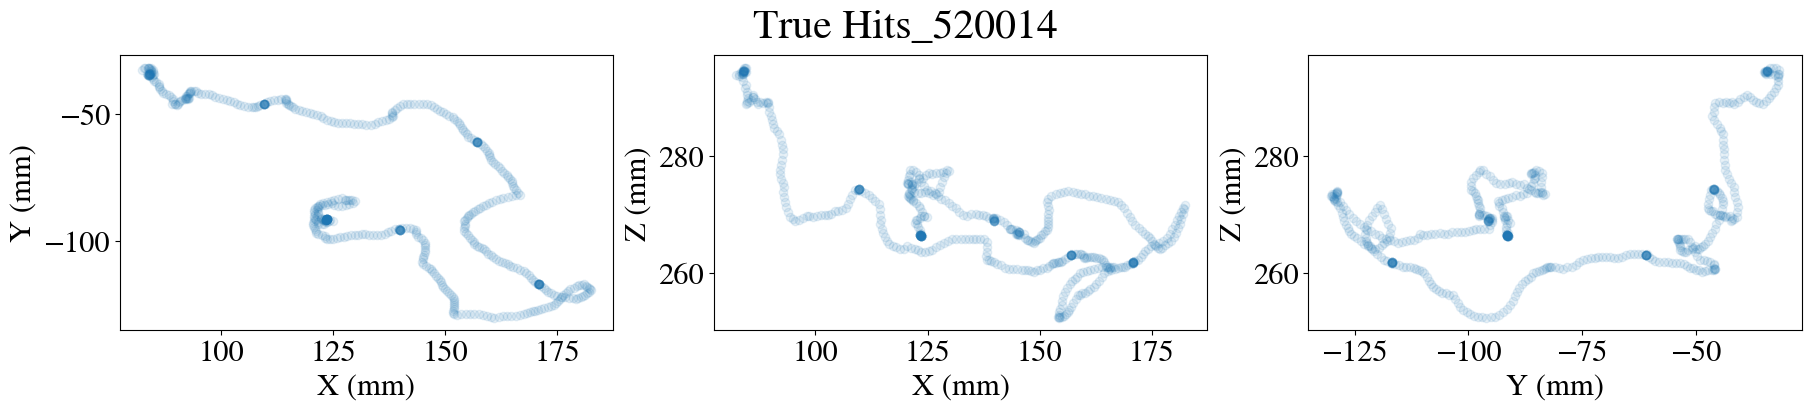

In [14]:
# select event
Q = 7

# limits
limit_spacing = 50 # put in the number required division-wise to produce a percentage
                    # eg: 10% of min and max means /10, 50% means /2

# Decides if plots are limited by the MC true info
lim_toggle = True

evt  = hdst.event.unique()[Q]

hits = hdst[hdst.event == evt]

display(hits)

# then the MC visualisation
this_evt_true_info = true_info[true_info.event_id == evt]

xt = this_evt_true_info.x
yt = this_evt_true_info.y
zt = this_evt_true_info.z
et = this_evt_true_info.energy*1000


fig, axes = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)
fig.suptitle('True Hits_' + str(evt), fontsize=30)

axes[0].scatter(xt, yt,  alpha=0.1)
axes[1].scatter(xt, zt,  alpha=0.1)
axes[2].scatter(yt, zt,  alpha=0.1)


axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

plt.show()



/tmp/ipykernel_11398/1598310876.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


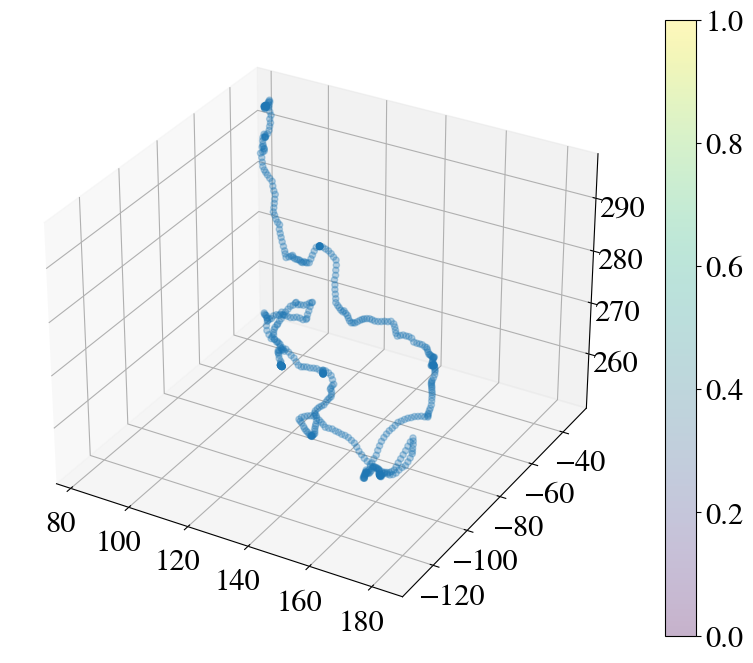

In [152]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(xt, yt, zt, alpha=0.3, cmap='cool')
plt.colorbar(p)
fig.show()

In [15]:
# collect min maxes

x_range = (hits.X.max()-hits.X.min())/2.
y_range = (hits.Y.max()-hits.Y.min())/2.
z_range = (hits.Z.max()-hits.Z.min())/2.
mid_x   = (hits.X.max()+hits.X.min())/2.
mid_y   = (hits.Y.max()+hits.Y.min())/2.
mid_z   = (hits.Z.max()+hits.Z.min())/2.
min_x = hits.X.min()
min_y = hits.Y.min()
min_z = hits.Z.min()

max_x = hits.X.max()
max_y = hits.Y.max()
max_z = hits.Z.max()
print("X maximum and minimum")
print(max_x, min_x)
print("")

print("Y maximum and minimum")
print(max_y, min_y)
print("")

print("Z maximum and minimum")
print(max_z, min_z)

xbins = int(hits.X.max()-hits.X.min())
ybins = int(hits.Y.max()-hits.Y.min())
zbins = int((hits.Z.max()-hits.Z.min())/2.)

X maximum and minimum
443.175 -272.125

Y maximum and minimum
225.475 -396.525

Z maximum and minimum
300.13301718750006 250.91151093750003


### visualise SiPM hits

Text(0.5, 0.98, 'SiPM Hits evt 520014')

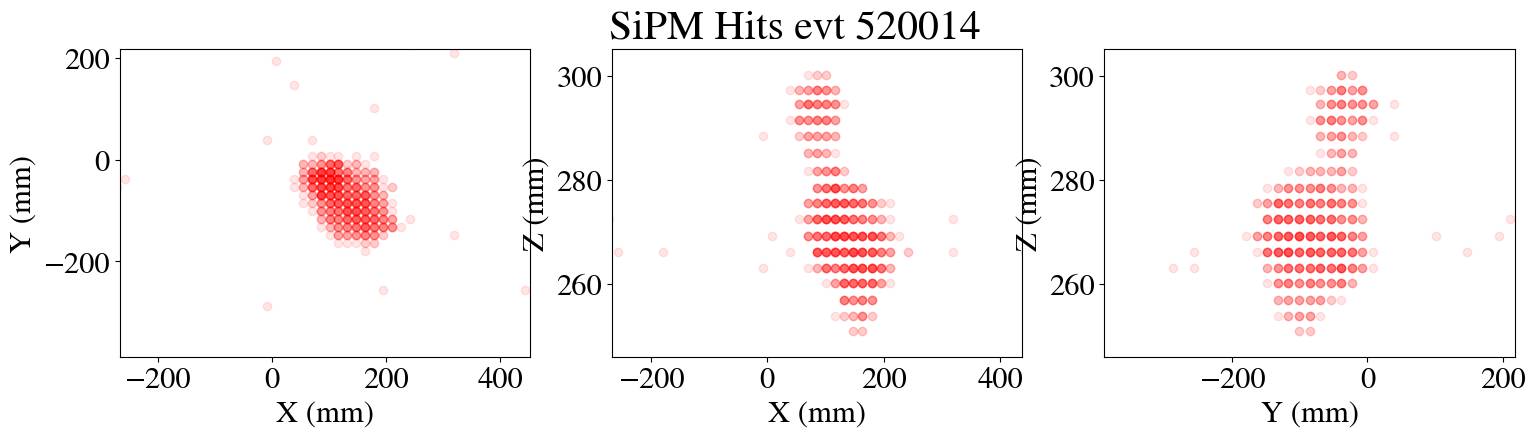

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].scatter(hits.X, hits.Y,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].scatter(hits.X, hits.Z,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].scatter(hits.Y, hits.Z,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


if lim_toggle == True:
    axes[0].set_xlim([min_x - min_x/limit_spacing, max_x + max_x/limit_spacing])
    axes[0].set_ylim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing])

    axes[1].set_xlim([min_x - min_x/limit_spacing, max_x + min_x/limit_spacing])
    axes[1].set_ylim([min_z - min_z/limit_spacing, max_z + min_z/limit_spacing])

    axes[2].set_xlim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing])
    axes[2].set_ylim([min_z - min_z/limit_spacing, max_z + min_z/limit_spacing])

    

fig.suptitle('SiPM Hits evt ' + str(evt), fontsize=30)

### Select a Z component

Values of Z to choose from:
[250.91151094 253.76459063 256.84309219 260.13543281 263.11352813
 266.19642656 269.28257344 272.41895625 275.49079688 278.50396875
 281.64671719 285.15640781 288.40724063 291.46152656 294.54120938
 297.344775   300.13301719]


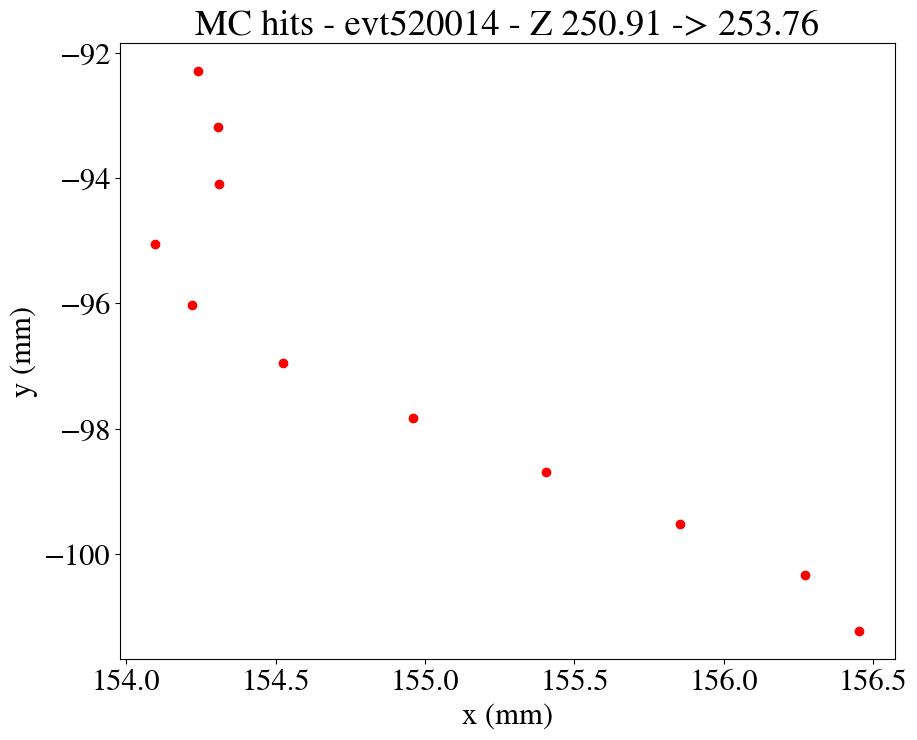

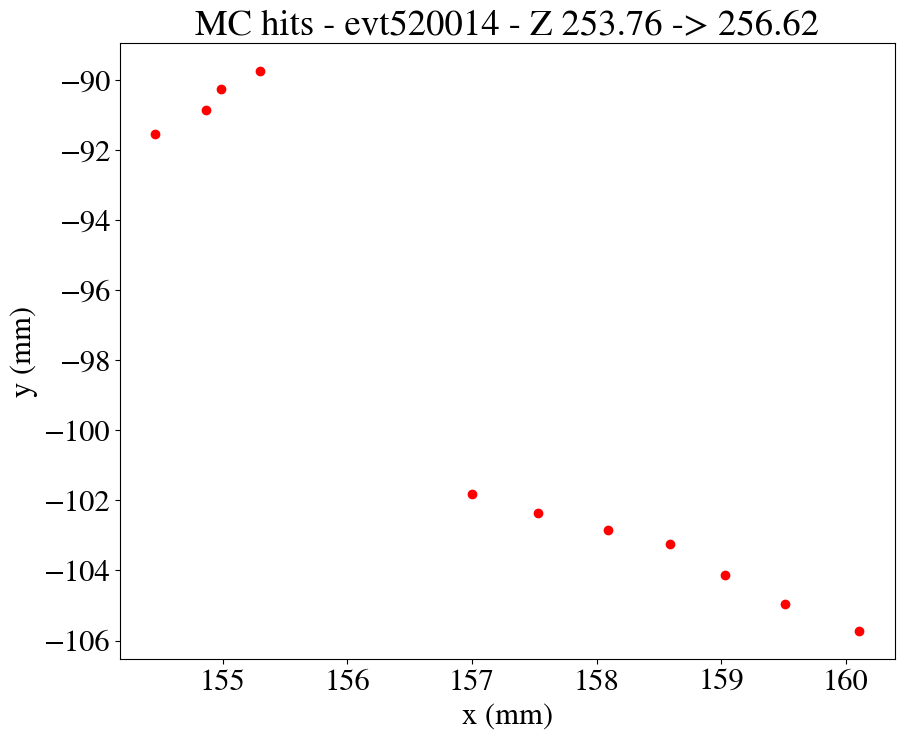

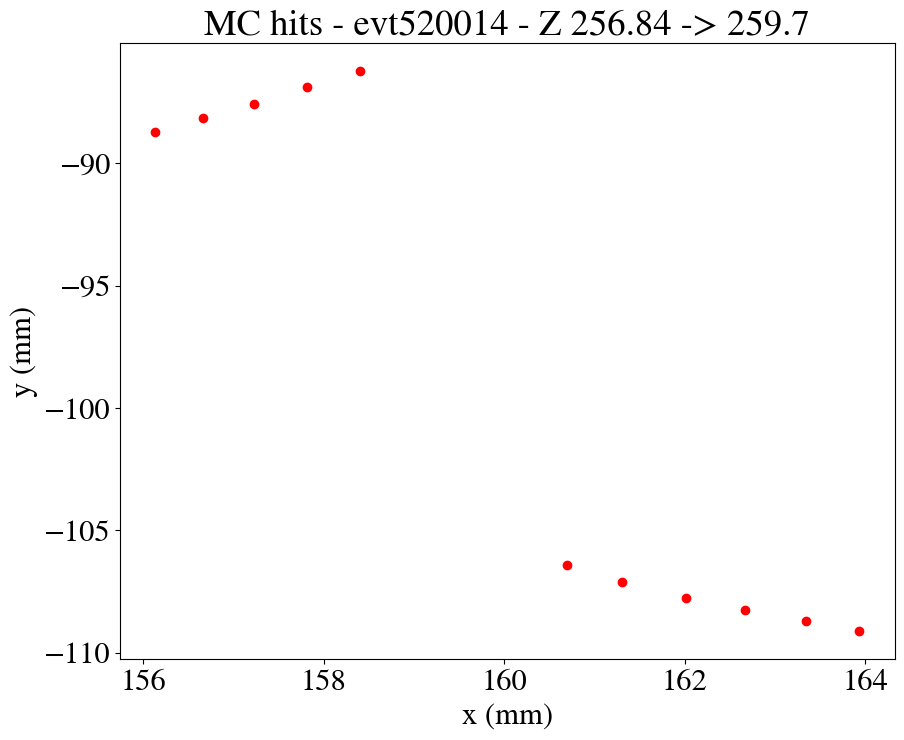

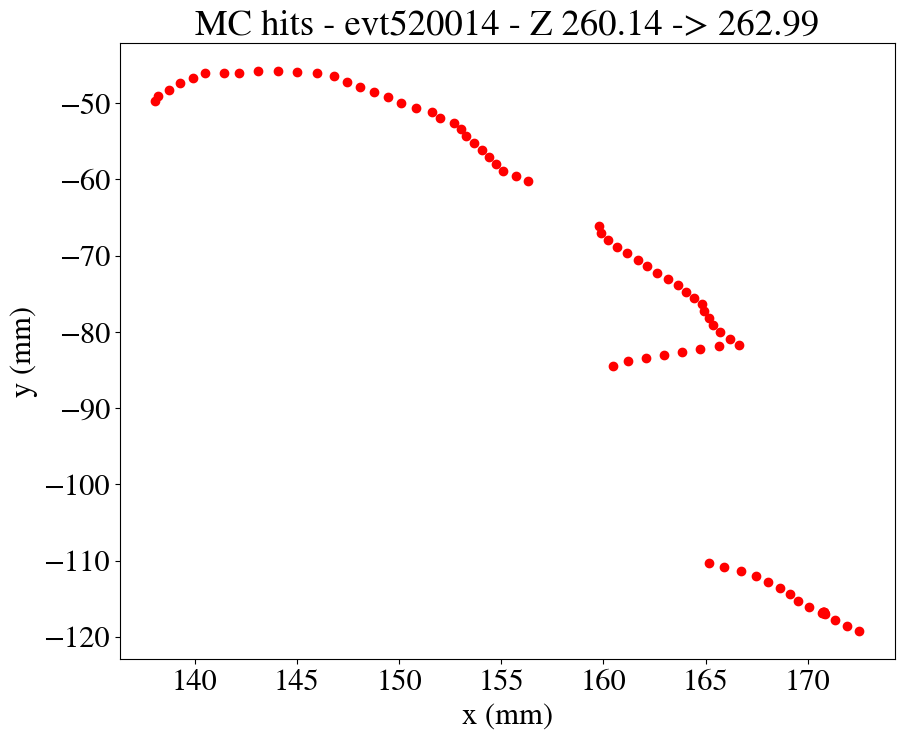

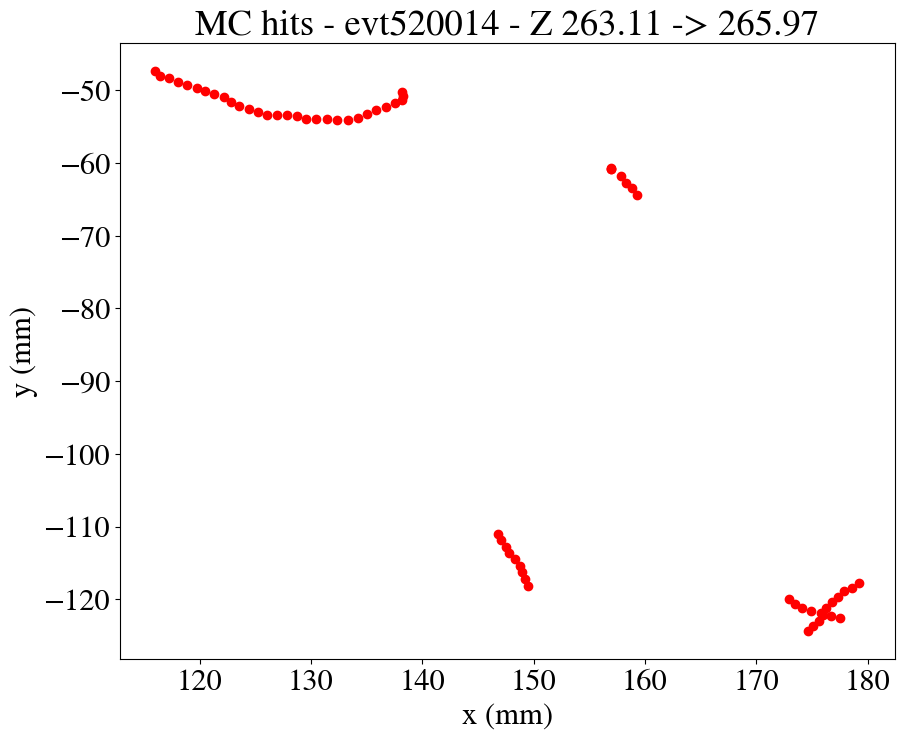

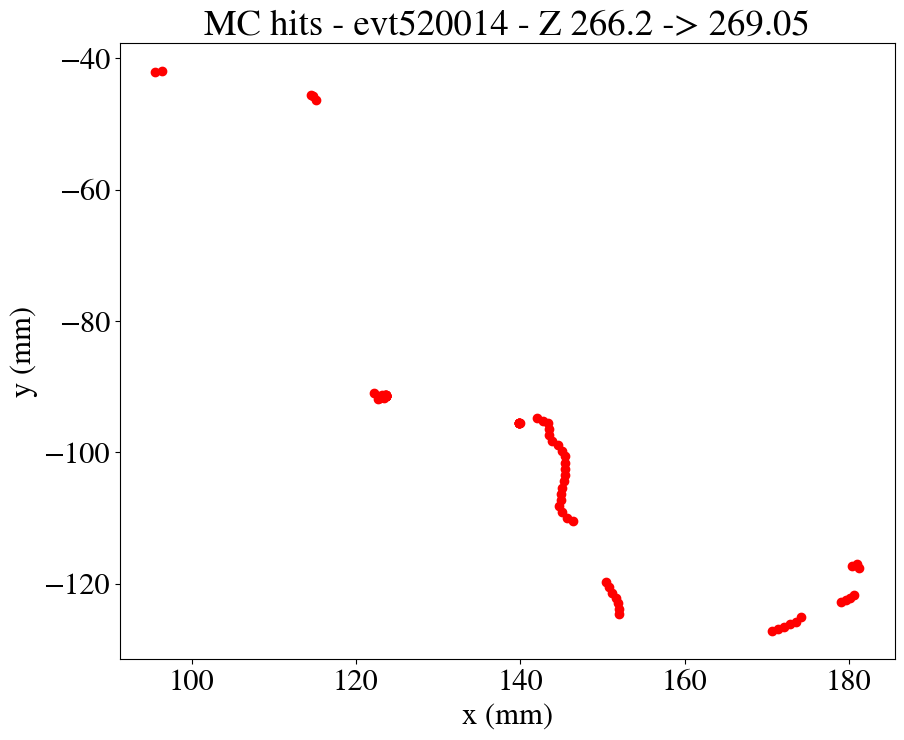

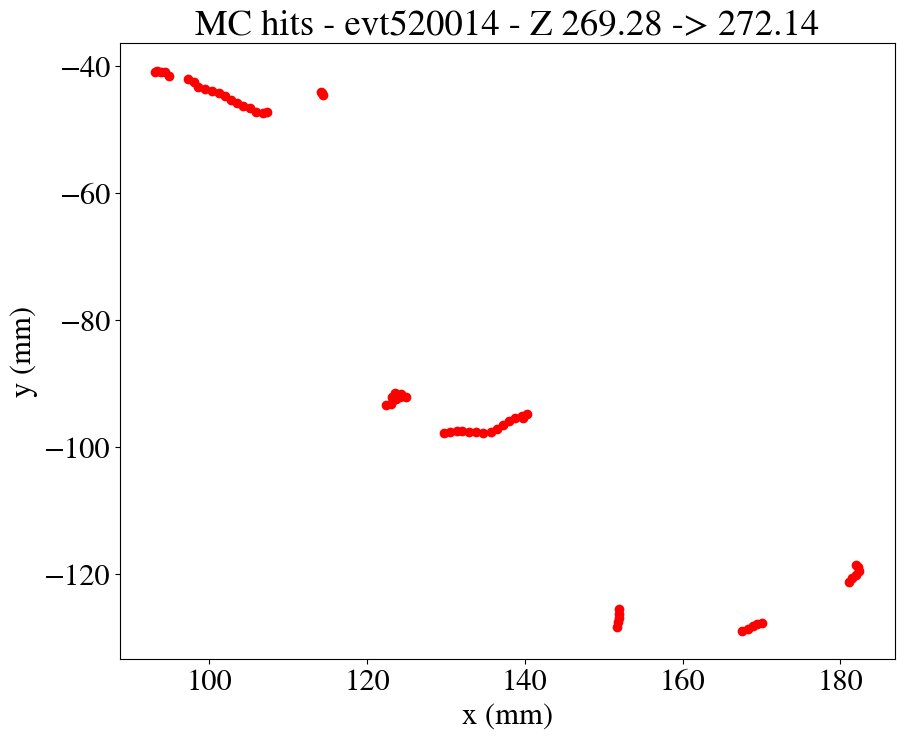

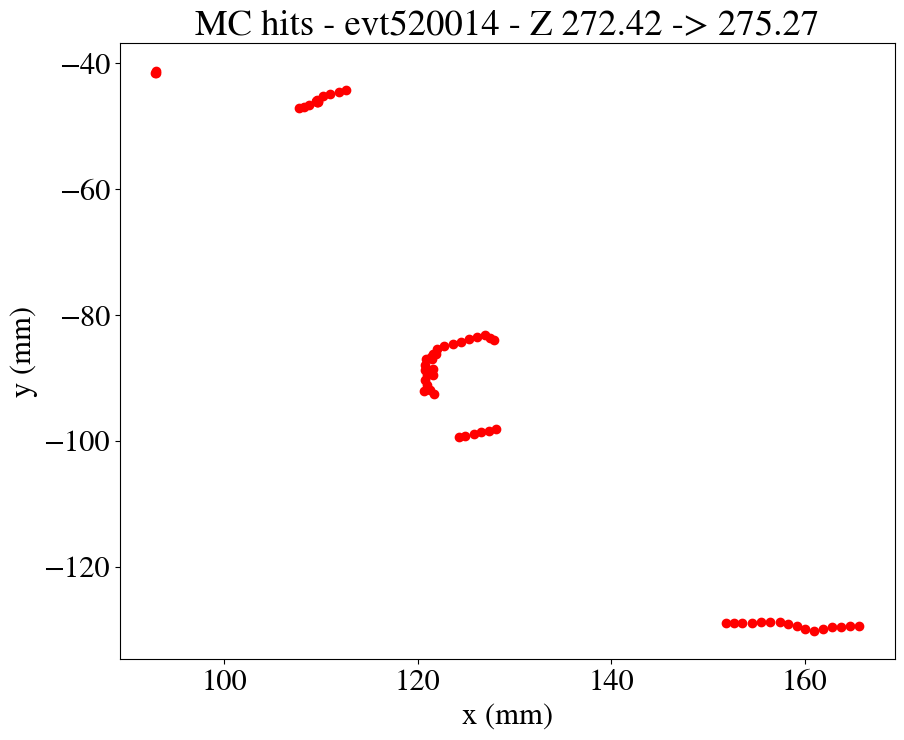

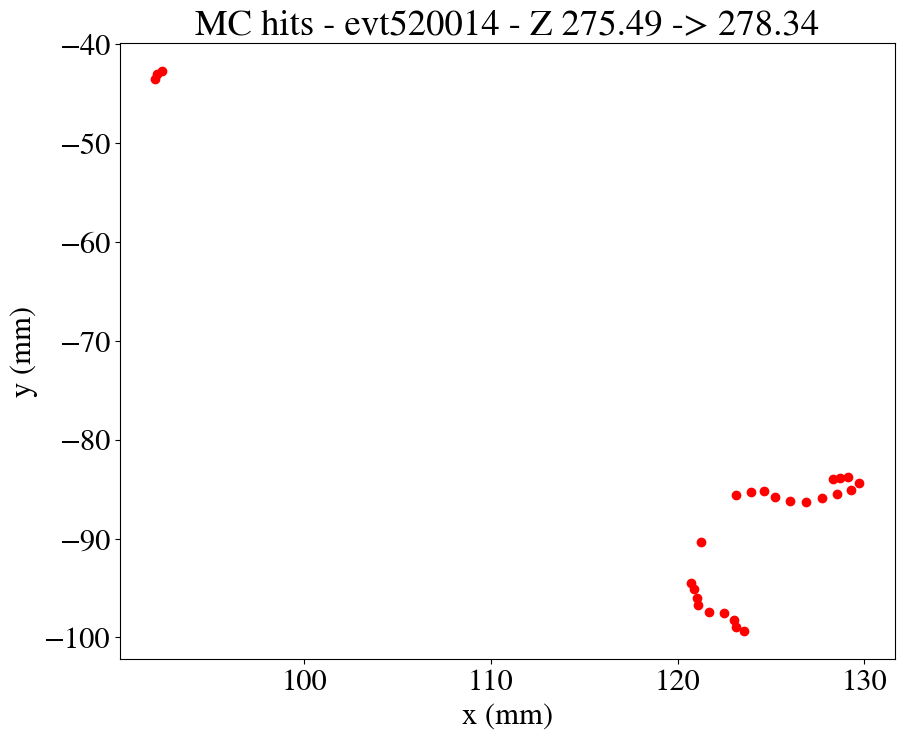

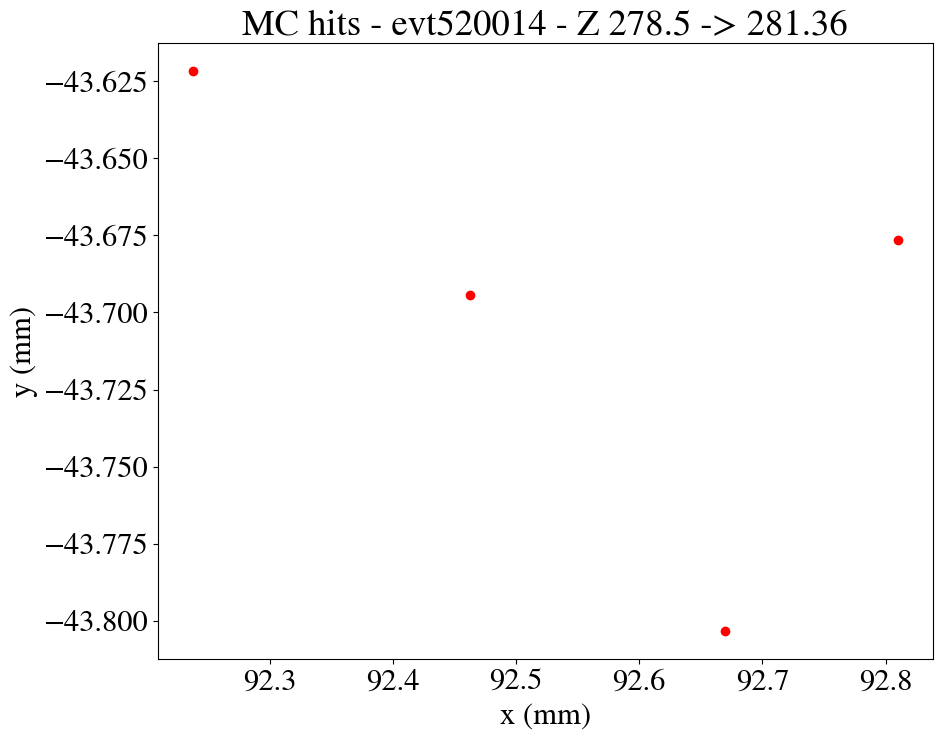

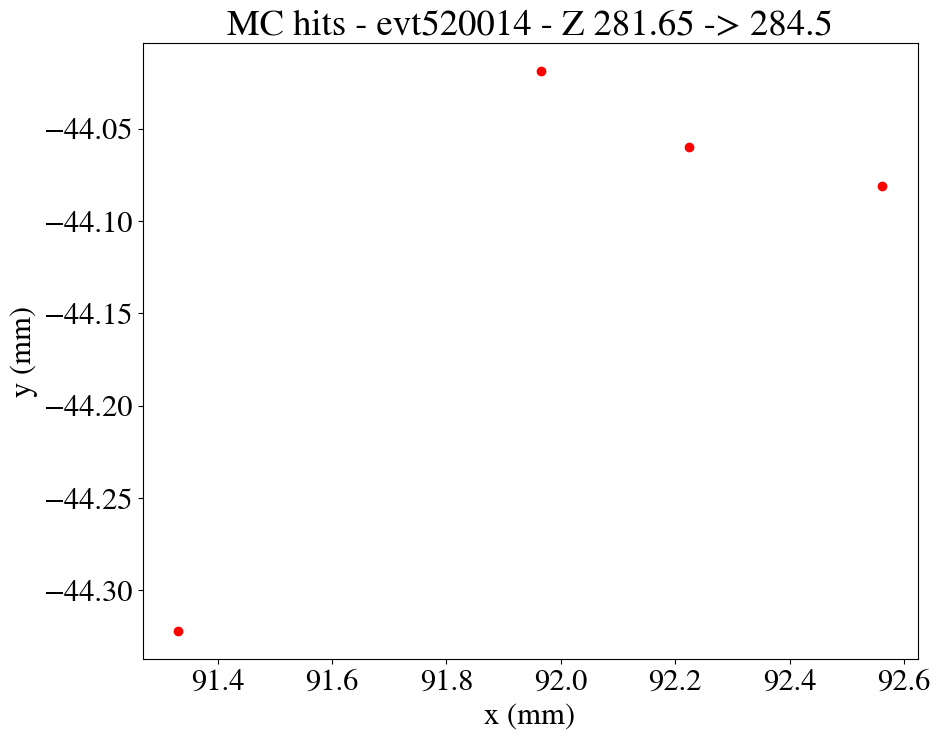

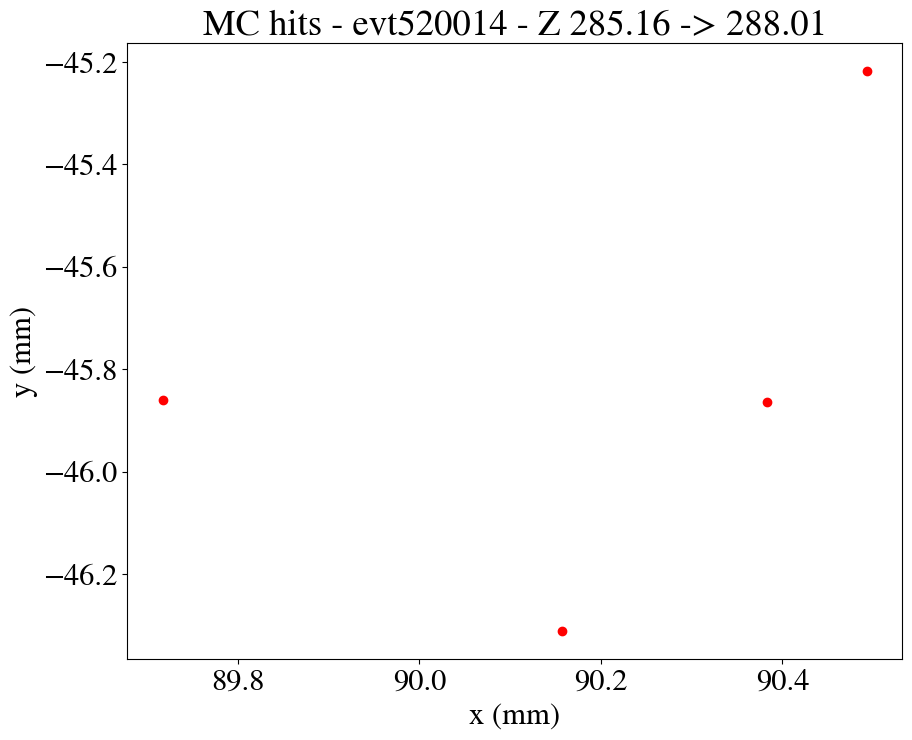

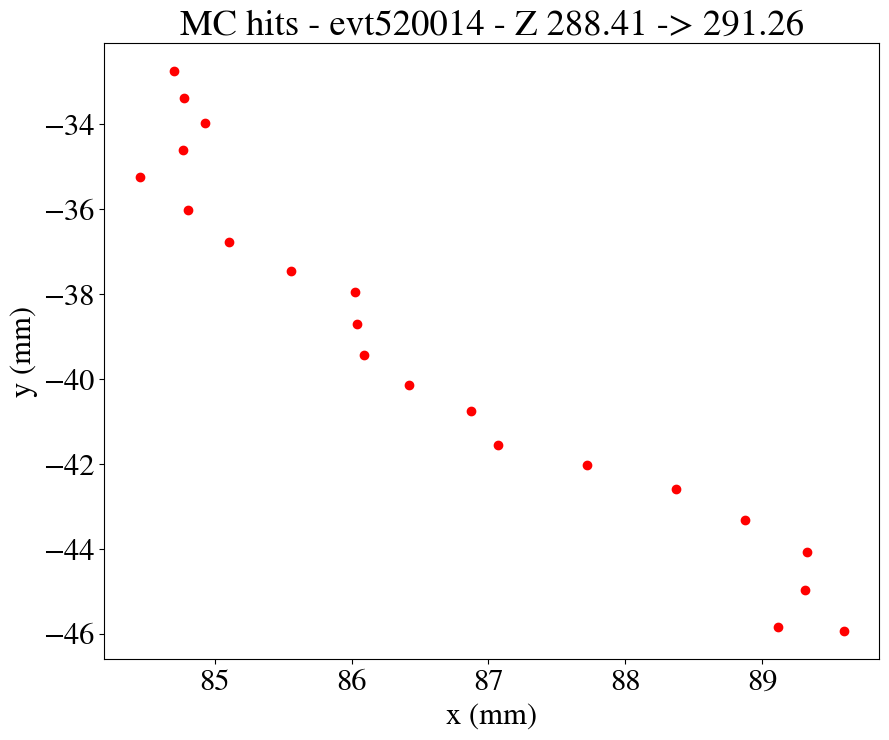

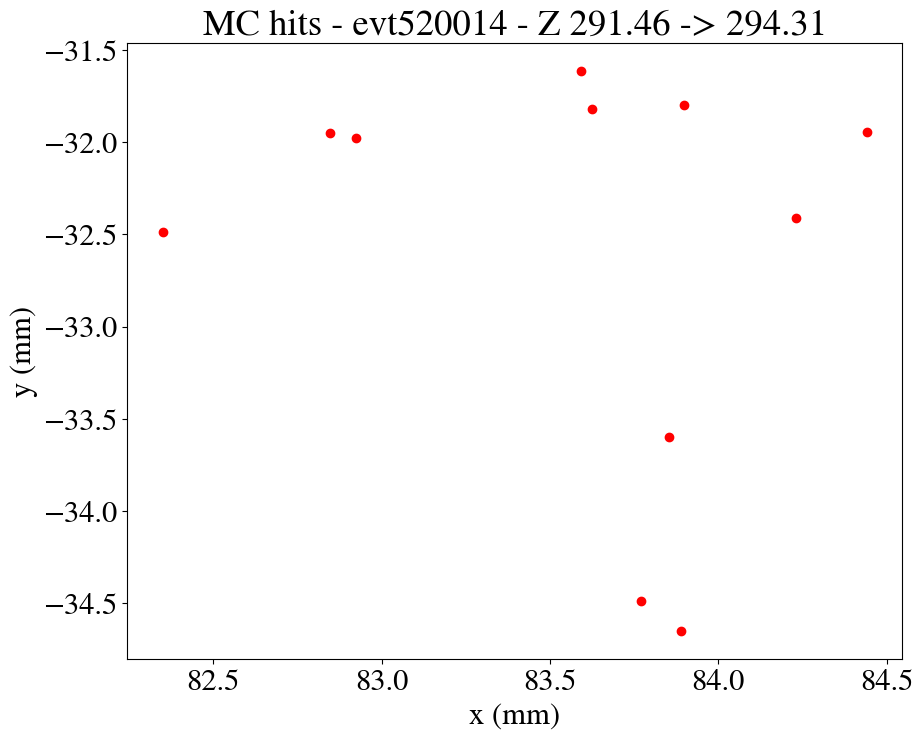

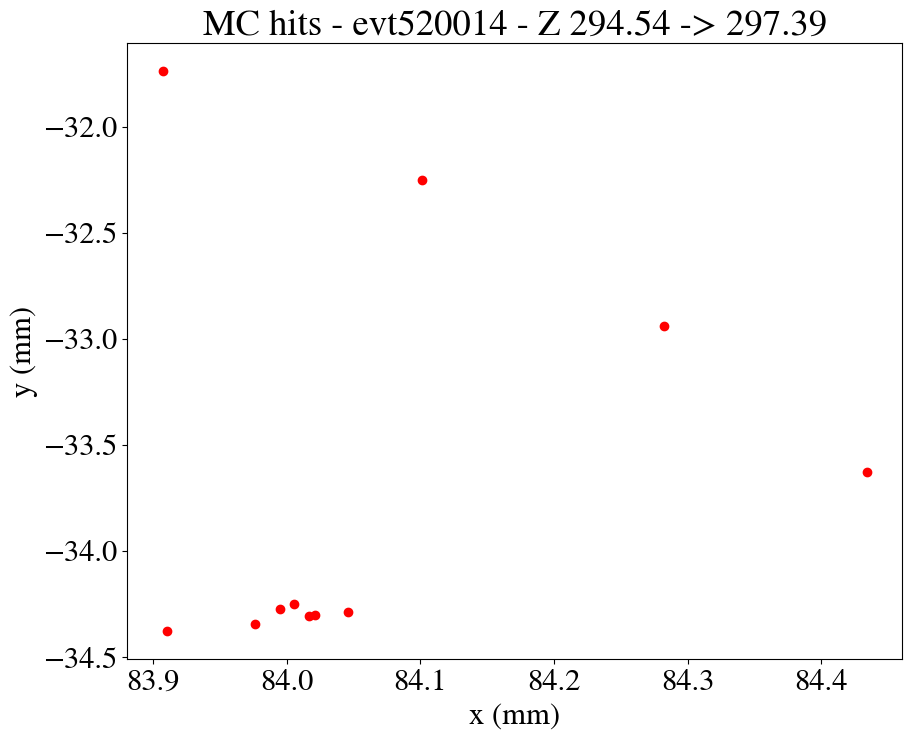

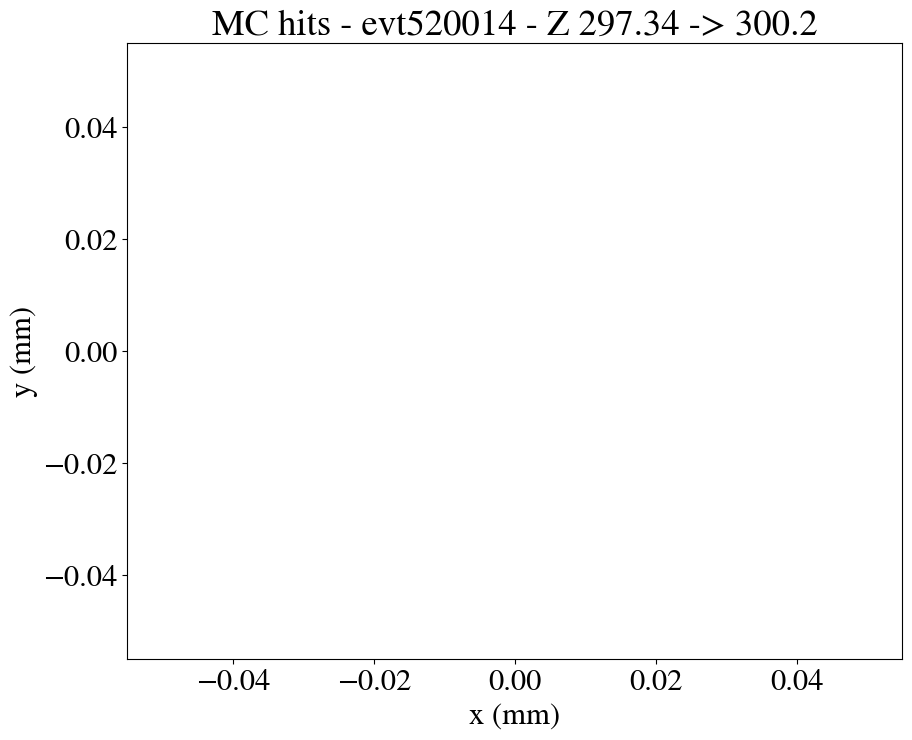

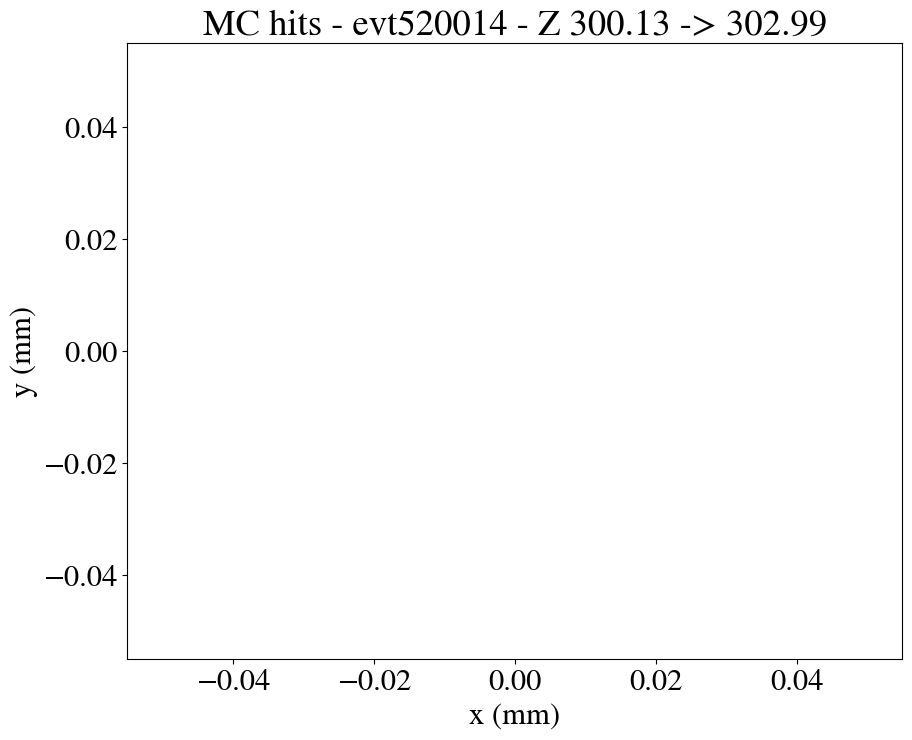

/tmp/ipykernel_11398/1779150102.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


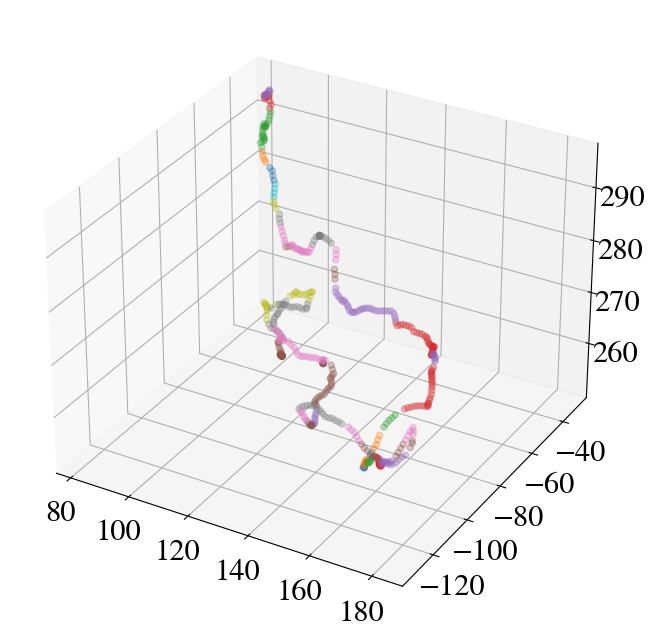

In [155]:
# select a singular Z slice of this df in the same manner as beersheba

#display(hits)
z_vals = hits.Z.unique()
# calculate spacing between the z_values
spacing = (z_vals[1] - z_vals[0]) / 2

print("Values of Z to choose from:")
print(z_vals)
for i in range(len(z_vals)):
    z_select = z_vals[i]

    hits_select = hits[hits.Z == z_select]
    #display(hits_select)


    # MC information
    z_low = z_select
    z_high = z_select + spacing*2
    Z_relevant_hits = this_evt_true_info[this_evt_true_info.z > z_low]
    Z_relevant_hits = Z_relevant_hits[Z_relevant_hits.z < z_high]


    # print the hits from MC
    x_vals = Z_relevant_hits.x
    y_vals = Z_relevant_hits.y
    plt.scatter(x_vals, y_vals, alpha=1, color='red')
    plt.title('MC hits - evt' + str(evt) + " - Z " + str(round(z_low, 2)) + " -> " + str(round(z_high, 2)))
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(z_vals)):
    z_select = z_vals[i]

    hits_select = hits[hits.Z == z_select]
    #display(hits_select)


    # MC information
    z_low = z_select
    z_high = z_select + spacing*2
    Z_relevant_hits = this_evt_true_info[this_evt_true_info.z > z_low]
    Z_relevant_hits = Z_relevant_hits[Z_relevant_hits.z < z_high]
    
    p = ax.scatter(Z_relevant_hits.x, Z_relevant_hits.y, Z_relevant_hits.z, alpha = 0.3, label = (str(z_low) + " - " + str(z_high)))

#plt.legend()
fig.show()


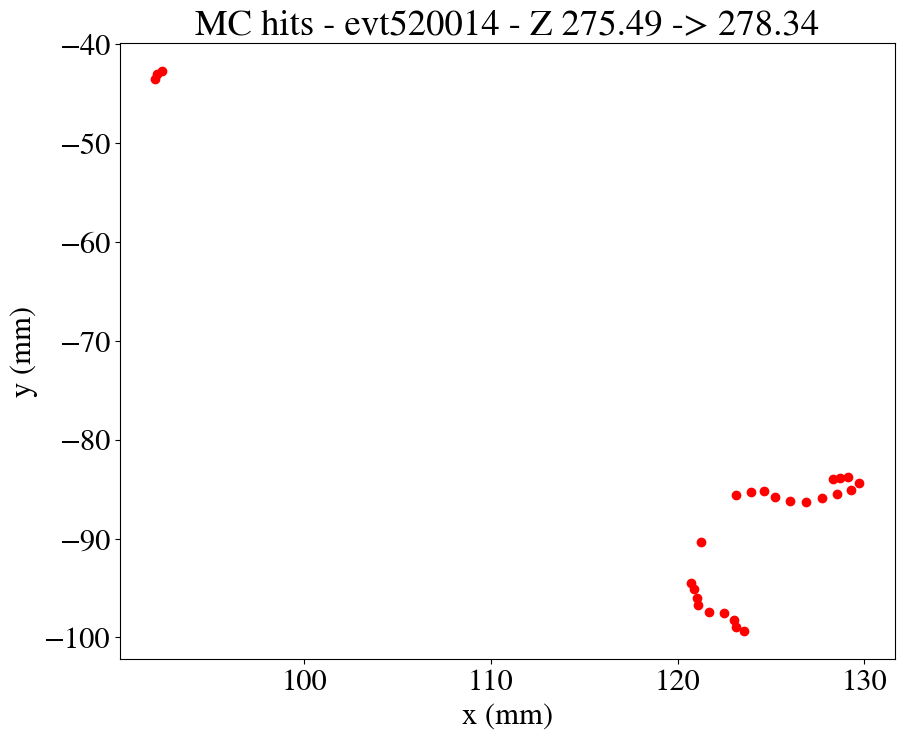

In [149]:
# print the hits from MC
x_vals = Z_relevant_hits.x
y_vals = Z_relevant_hits.y
plt.scatter(x_vals, y_vals, alpha=1, color='red')
plt.title('MC hits - evt' + str(evt) + " - Z " + str(round(z_low, 2)) + " -> " + str(round(z_high, 2)))
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

### do the basic cuts

drop_sensors, etc

Z val selected: 250.91151093750003


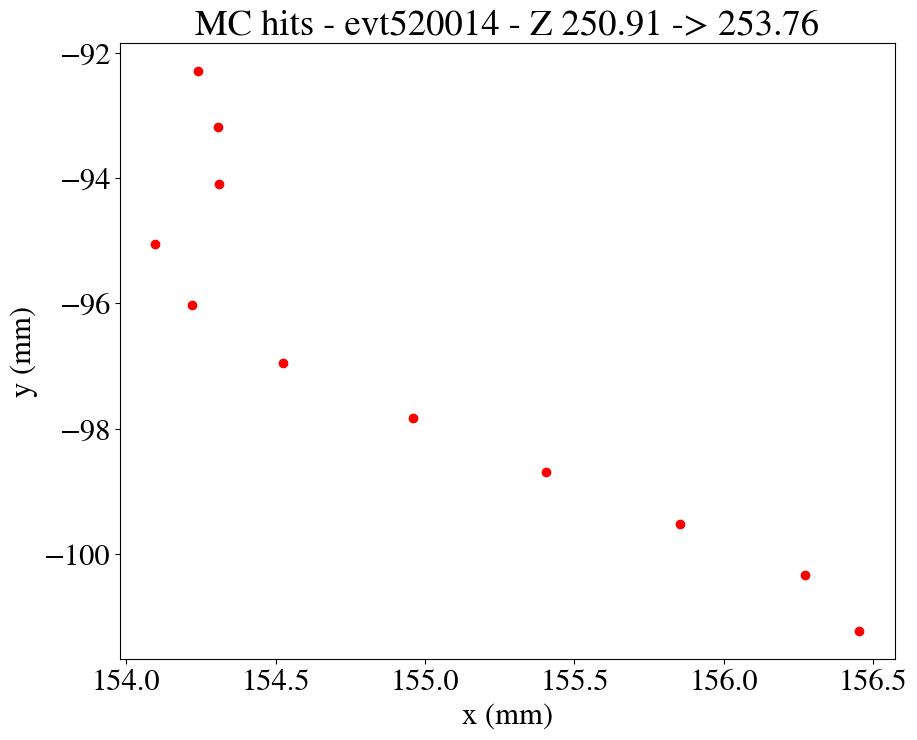

In [158]:
# z select
z_select = z_vals[0]

print("Z val selected: {}".format(z_select))

hits_select = hits[hits.Z == z_select]


# MC information
z_low = z_select
z_high = z_select + spacing*2
Z_relevant_hits = this_evt_true_info[this_evt_true_info.z > z_low]
Z_relevant_hits = Z_relevant_hits[Z_relevant_hits.z < z_high]
# print the hits from MC
x_vals = Z_relevant_hits.x
y_vals = Z_relevant_hits.y
plt.scatter(x_vals, y_vals, alpha=1, color='red')
plt.title('MC hits - evt' + str(evt) + " - Z " + str(round(z_low, 2)) + " -> " + str(round(z_high, 2)))
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

Time spent in cut_over_Q: 0.02342367172241211 s
Time spent in drop_isolated: 0.013376712799072266 s


/tmp/ipykernel_11398/2676957056.py:18: UserWarning: Attempting to set identical bottom == top == 300.13301718750006 results in singular transformations; automatically expanding.
  axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
/tmp/ipykernel_11398/2676957056.py:24: UserWarning: Attempting to set identical bottom == top == 300.13301718750006 results in singular transformations; automatically expanding.
  axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);


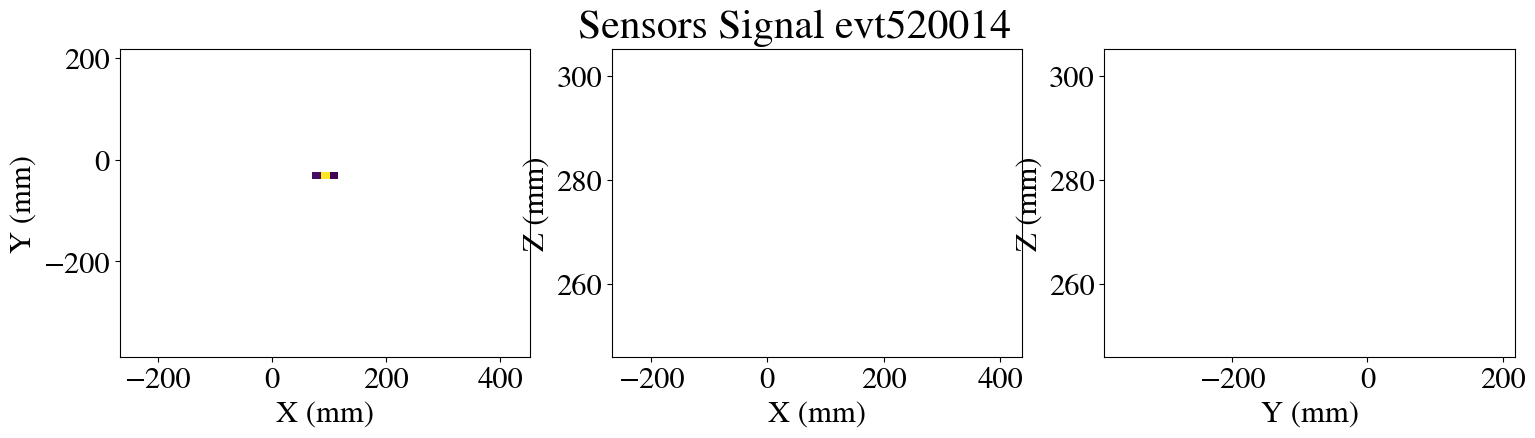

In [156]:
# basic custs
hits_cut = coref.timefunc(cut_sensors)(hits_select.copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
# plot the event pre-deconv

# then applying transformations to convert to 'SiPM outputs'
fig, axes = plt.subplots(1, 3, figsize=(18, 4))


xx = np.arange(hits_drop.X.min(), hits_drop.X.max() + pitch, pitch)
yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max() + pitch, pitch)
zz = hits_drop.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');
#axes[1].axhspan(272.41895625 - spacing, 272.41895625 + spacing, color = 'red', alpha = 0.5)


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');
#axes[2].axhspan(272.41895625 - spacing, 272.41895625 + spacing, color = 'red', alpha = 0.5)

fig.suptitle('Sensors Signal evt' + str(evt), fontsize=30)


if lim_toggle == True:
    axes[0].set_xlim([min_x - min_x/limit_spacing, max_x + max_x/limit_spacing])
    axes[0].set_ylim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing])

    axes[1].set_xlim([min_x - min_x/limit_spacing, max_x + min_x/limit_spacing])
    axes[1].set_ylim([min_z - min_z/limit_spacing, max_z + min_z/limit_spacing])

    axes[2].set_xlim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing])
    axes[2].set_ylim([min_z - min_z/limit_spacing, max_z + min_z/limit_spacing])

    

In [126]:
deconv_params_['n_iterations'] = 400
deconv_params_['satellite_iter'] = 25

outwith deconvolve
Applying deconv


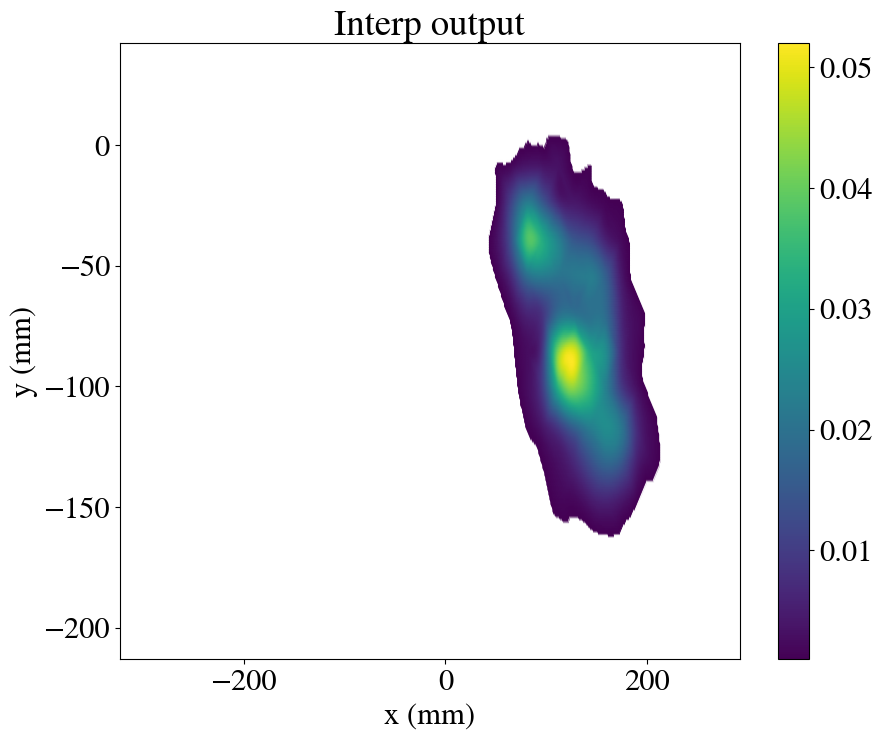

/tmp/ipykernel_11398/1402852692.py:327: RuntimeWarning: divide by zero encountered in true_divide
  rel_diff = np.sum(np.nan_to_num(np.divide(((im_deconv/im_deconv.max() - ref_image)**2), ref_image)))
/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_11398/1402852692.py:327: RuntimeWarning: invalid value encountered in true_divide
  rel_diff = np.sum(np.nan_to_num(np.divide(((im_deconv/im_deconv.max() - ref_image)**2), ref_image)))


[inf, 1044.3714215235216, 227.07551431412531, 89.23049021198848, 46.75109249765941, 28.954040090174427, 19.321610872886193, 13.801951531574144, 10.05276288013092, 7.9348887644741986, 6.11005185879058, 4.810433208285585, 3.8613607795330114, 3.3287696928896726, 2.764803959638134, 2.3196739047522, 1.9686510717926988, 1.6882316925340433, 1.461382903285298, 1.2757060508781206, 1.1221781900631422, 0.9941731982381783, 0.9137771408718542, 0.8355841425757247, 0.7526953906683846, 0.680323062450316, 0.6163205790824531, 0.5594207401839626, 0.5089037736266011, 0.464208360641264, 0.4247317327129311, 0.38982280534552954, 0.3588478442962175, 0.3312421624920518, 0.3065271851937782, 0.2843042872388401, 0.2642409834300729, 0.2460592206059052, 0.22952763671211526, 0.21445451955072384, 0.2006793972412587, 0.1880649510048518, 0.17649140376437134, 0.16585337868684918, 0.15605799810067172, 0.1470233440297996, 0.13867704362536912, 0.1309550072424849, 0.12380034692787528, 0.11716245728069688, 0.1109962262735742

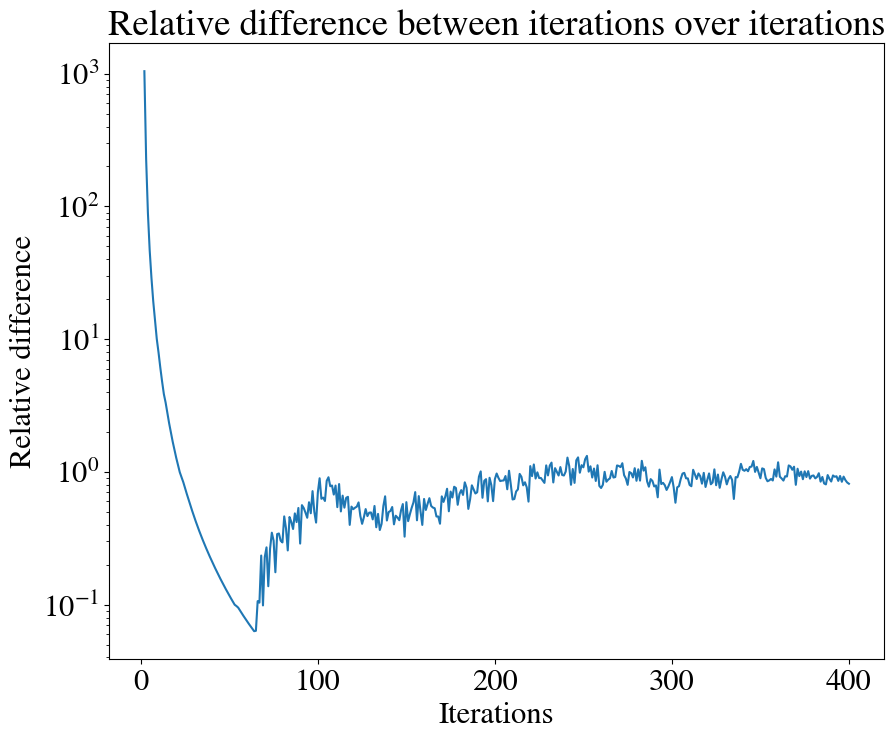


[PosixPath('gif_making_folder/iterthr'), PosixPath('gif_making_folder/deconv'), PosixPath('gif_making_folder/mask')]
Directory gif_making_folder/iterthr
['iter0.png', 'iter1.png', 'iter2.png', 'iter3.png', 'iter4.png', 'iter5.png', 'iter6.png', 'iter7.png', 'iter8.png', 'iter9.png', 'iter10.png', 'iter11.png', 'iter12.png', 'iter13.png', 'iter14.png', 'iter15.png', 'iter16.png', 'iter17.png', 'iter18.png', 'iter19.png', 'iter20.png', 'iter21.png', 'iter22.png', 'iter23.png', 'iter24.png', 'iter25.png', 'iter26.png', 'iter27.png', 'iter28.png', 'iter29.png', 'iter30.png', 'iter31.png', 'iter32.png', 'iter33.png', 'iter34.png', 'iter35.png', 'iter36.png', 'iter37.png', 'iter38.png', 'iter39.png', 'iter40.png', 'iter41.png', 'iter42.png', 'iter43.png', 'iter44.png', 'iter45.png', 'iter46.png', 'iter47.png', 'iter48.png', 'iter49.png', 'iter50.png', 'iter51.png', 'iter52.png', 'iter53.png', 'iter54.png', 'iter55.png', 'iter56.png', 'iter57.png', 'iter58.png', 'iter59.png', 'iter60.png', '

/tmp/ipykernel_11398/1402852692.py:397: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(active_dir + filename))


Saving gif at /home/e78368jw/Documents/NEXT_CODE/next_misc/miscellaneous/
Directory gif_making_folder/deconv
['iter0.png', 'iter1.png', 'iter2.png', 'iter3.png', 'iter4.png', 'iter5.png', 'iter6.png', 'iter7.png', 'iter8.png', 'iter9.png', 'iter10.png', 'iter11.png', 'iter12.png', 'iter13.png', 'iter14.png', 'iter15.png', 'iter16.png', 'iter17.png', 'iter18.png', 'iter19.png', 'iter20.png', 'iter21.png', 'iter22.png', 'iter23.png', 'iter24.png', 'iter25.png', 'iter26.png', 'iter27.png', 'iter28.png', 'iter29.png', 'iter30.png', 'iter31.png', 'iter32.png', 'iter33.png', 'iter34.png', 'iter35.png', 'iter36.png', 'iter37.png', 'iter38.png', 'iter39.png', 'iter40.png', 'iter41.png', 'iter42.png', 'iter43.png', 'iter44.png', 'iter45.png', 'iter46.png', 'iter47.png', 'iter48.png', 'iter49.png', 'iter50.png', 'iter51.png', 'iter52.png', 'iter53.png', 'iter54.png', 'iter55.png', 'iter56.png', 'iter57.png', 'iter58.png', 'iter59.png', 'iter60.png', 'iter61.png', 'iter62.png', 'iter63.png', 'ite

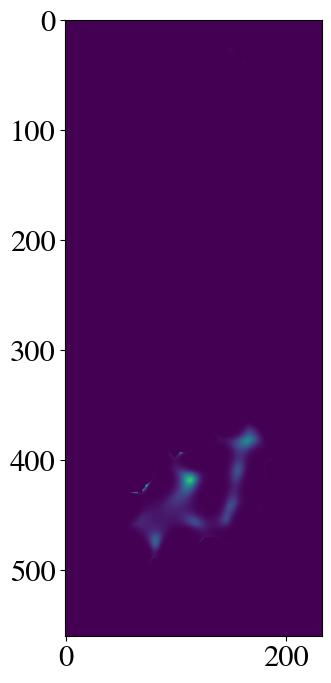

In [127]:
output = z_slice_deconvolve(DataSiPM(detector_db, run_number), hits_drop, z_select, **deconv_params_)

,event,npeak,X,Y,Z,E,Xpeak,Ypeak
0,520014,0,71.875,-36.425,250.911511,0.000073,130.671205,-77.432837
1,520014,0,71.875,-35.425,250.911511,0.000079,130.671205,-77.432837
2,520014,0,71.875,-34.425,250.911511,0.000077,130.671205,-77.432837
3,520014,0,71.875,-33.425,250.911511,0.000068,130.671205,-77.432837
4,520014,0,72.875,-38.425,250.911511,0.000075,130.671205,-77.432837
...,...,...,...,...,...,...,...,...
4825,520014,0,193.875,-119.425,250.911511,0.000105,130.671205,-77.432837
4826,520014,0,194.875,-124.425,250.911511,0.000064,130.671205,-77.432837
4827,520014,0,194.875,-123.425,250.911511,0.000150,130.671205,-77.432837
4828,520014,0,195.875,-124.425,250.911511,0.000129,130.671205,-77.432837


' if lim_toggle == True:\n    plt.set_xlim([min_x - min_x/limit_spacing, max_x + max_x/limit_spacing])\n    plt.set_ylim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing]) '

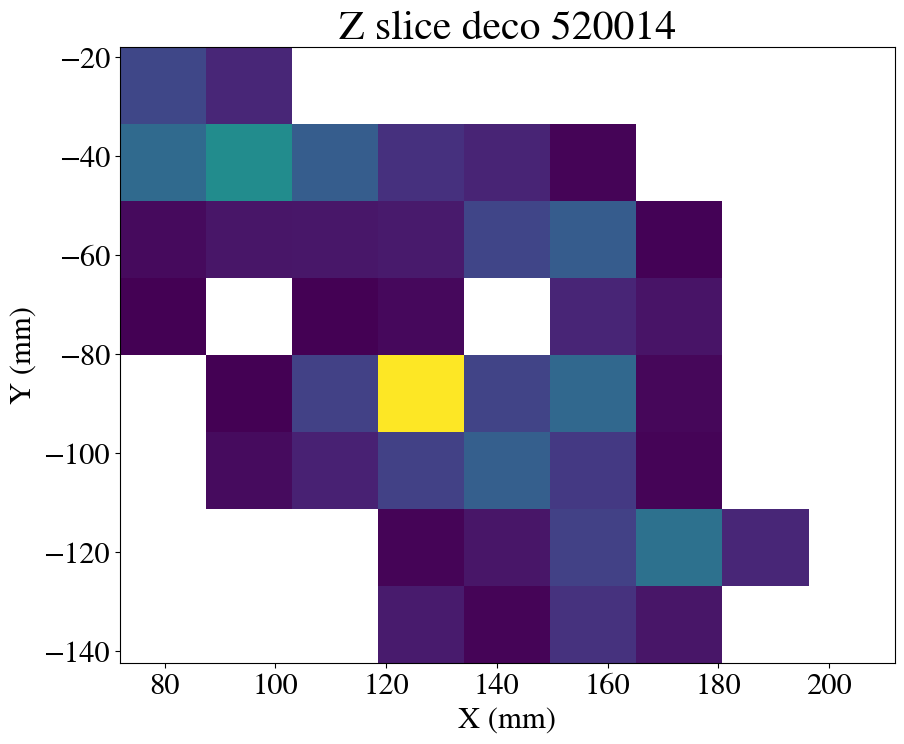

In [129]:
display(output)


xx = np.arange(output.X.min(), output.X.max() + pitch, pitch)
yy = np.arange(output.Y.min(), output.Y.max() + pitch, pitch)

plt.hist2d(output.X, output.Y, bins=[xx, yy], weights=output.E, cmin=0.0001);
plt.xlabel('X (mm)');
plt.ylabel('Y (mm)');
plt.title('Z slice deco ' + str(evt), fontsize=30)


""" if lim_toggle == True:
    plt.set_xlim([min_x - min_x/limit_spacing, max_x + max_x/limit_spacing])
    plt.set_ylim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing]) """

Text(0.5, 1.0, 'z slice output')

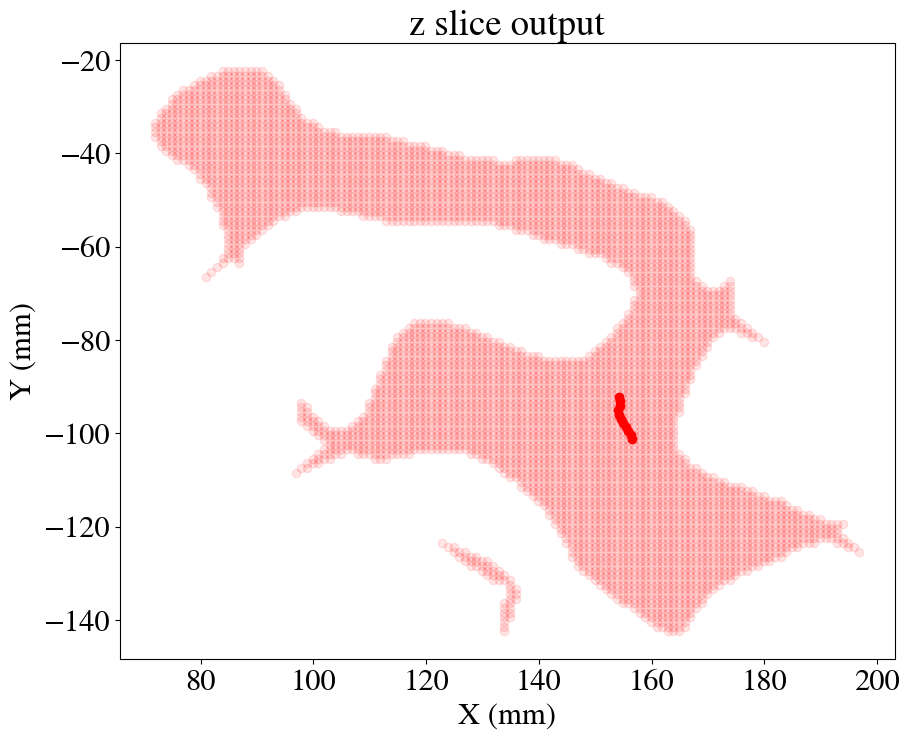

In [140]:

plt.scatter(output.X, output.Y,  alpha=0.1, color='red')
plt.scatter(x_vals, y_vals, alpha=1, color='red')
plt.xlabel('X (mm)');
plt.ylabel('Y (mm)');
    

plt.title('z slice output')